In [ ]:
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#   print('Not using a high-RAM runtime')
# else:
#   print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout


In [ ]:
import os
from google.colab import files

# Upload files - can uncomment as necessary if you need to upload your own files
uploaded = files.upload()

# List the files uploaded
print("Uploaded files:", uploaded.keys())

# Load files into DataFrames
symptoms_df = pd.read_csv('symptoms_top_50.csv')
symptoms_df.rename(columns={'preferred_name': 'extracted_symptoms'}, inplace=True)

diagnosis_df = pd.read_csv('DIAGNOSES_ICD.csv')

# Print the DataFrames
print(symptoms_df.head())
print(diagnosis_df.head())

# Print their shapes
print(symptoms_df.shape)
print(diagnosis_df.shape)



Saving DIAGNOSES_ICD.csv to DIAGNOSES_ICD.csv
Saving symptoms_top_50.csv to symptoms_top_50.csv
Uploaded files: dict_keys(['DIAGNOSES_ICD.csv', 'symptoms_top_50.csv'])
   SUBJECT_ID  HADM_ID                                 extracted_symptoms
0           6   107064  ['Discharge, body substance', 'Chronic kidney ...
1           9   150750  ['Discharge, body substance', 'Weakness', 'Wea...
2          10   184167  ['Discharge, body substance', 'BRAF Gene Rearr...
3          12   112213  ['Discharge, body substance', 'Hypertensive di...
4          13   143045  ['Discharge, body substance', 'PSA Level Less ...
   ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
0    1297         109   172335      1.0     40301
1    1298         109   172335      2.0       486
2    1299         109   172335      3.0     58281
3    1300         109   172335      4.0      5855
4    1301         109   172335      5.0      4254
(27209, 3)
(651047, 5)


<ipython-input-4-c5b308afbc0e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnoses_df['ICD9_CODE'] = diagnoses_df['ICD9_CODE'].astype(str)
<ipython-input-4-c5b308afbc0e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnoses_df['ICD9_CODE'] = diagnoses_df['ICD9_CODE'].astype(str).str[:3]


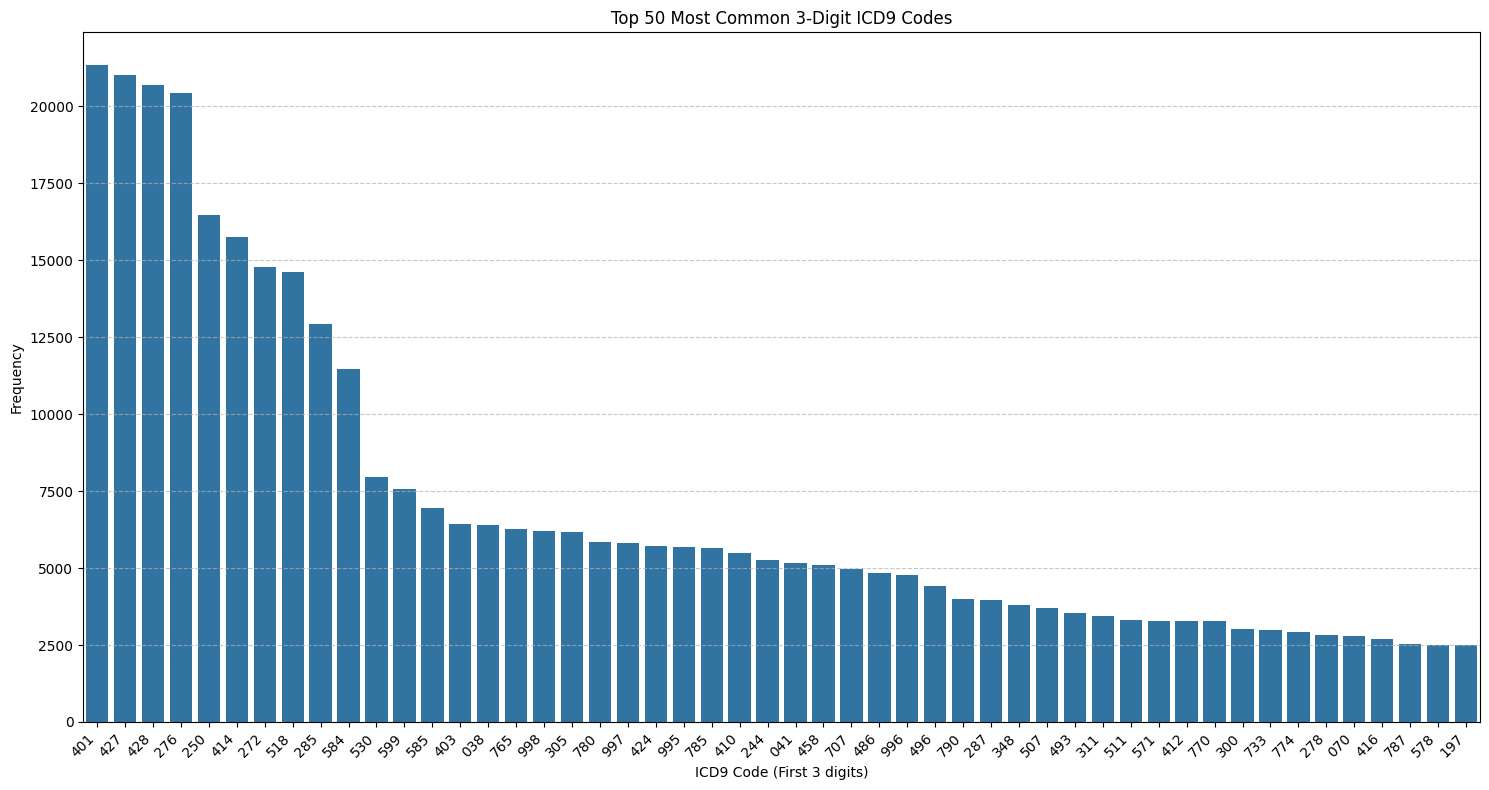

In [ ]:
#Visualize the distribution of ICD codes

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess diagnoses
diagnoses_df = pd.read_csv('DIAGNOSES_ICD.csv')

# Remove any rows with NaN ICD9_CODE
diagnoses_df = diagnoses_df.dropna(subset=['ICD9_CODE'])

# Convert to string and filter out E and V codes
diagnoses_df['ICD9_CODE'] = diagnoses_df['ICD9_CODE'].astype(str)
diagnoses_df = diagnoses_df[~diagnoses_df['ICD9_CODE'].str.startswith(('E', 'V'))]

# Convert to 3-digit ICD9 codes
diagnoses_df['ICD9_CODE'] = diagnoses_df['ICD9_CODE'].astype(str).str[:3]

# Count frequency of each 3-digit code
code_counts = diagnoses_df['ICD9_CODE'].value_counts()

# Create a bar plot
plt.figure(figsize=(15, 8))
sns.barplot(x=code_counts.head(50).index, y=code_counts.head(50).values)

plt.title('Top 50 Most Common 3-Digit ICD9 Codes')
plt.xlabel('ICD9 Code (First 3 digits)')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

print("Original shape:", diagnosis_df.shape)

# Create composite key
diagnosis_df['PATIENT_VISIT'] = diagnosis_df['SUBJECT_ID'].astype(str) + '_' + diagnosis_df['HADM_ID'].astype(str)

# Basic preprocessing
# Remove rows with NaN codes
diagnosis_df = diagnosis_df.dropna(subset=['ICD9_CODE'])

# Convert to string
diagnosis_df['ICD9_CODE'] = diagnosis_df['ICD9_CODE'].astype(str)

# Remove E and V codes
diagnosis_df = diagnosis_df[~diagnosis_df['ICD9_CODE'].str.startswith('E') &
                          ~diagnosis_df['ICD9_CODE'].str.startswith('V')]

# Take first 3 digits
diagnosis_df['ICD9_CODE'] = diagnosis_df['ICD9_CODE'].str[:3]

# Get top 50 codes
top_50_codes = diagnosis_df['ICD9_CODE'].value_counts().nlargest(50).index.tolist()
print("\nTop 50 diagnosis codes:", top_50_codes)

# Filter and remove duplicates
diagnosis_df = diagnosis_df[diagnosis_df['ICD9_CODE'].isin(top_50_codes)]
diagnosis_df = diagnosis_df.drop_duplicates(subset=['PATIENT_VISIT', 'ICD9_CODE'])

# Verify PATIENT_VISIT is a valid primary key
duplicate_visits = diagnosis_df['PATIENT_VISIT'].value_counts()
print("\nNumber of diagnoses per patient visit:")
print(duplicate_visits.describe())
print("\nNumber of unique patient visits:", len(diagnosis_df['PATIENT_VISIT'].unique()))
print("Total number of rows:", len(diagnosis_df))

# Group by PATIENT_VISIT and create diagnoses lists
diagnoses_grouped = diagnosis_df.groupby('PATIENT_VISIT').agg({
    'SUBJECT_ID': 'first',
    'HADM_ID': 'first',
    'ICD9_CODE': list
}).reset_index()

# Create final DataFrame
final_diagnoses_df = pd.DataFrame({
    'PATIENT_VISIT': diagnoses_grouped['PATIENT_VISIT'],
    'SUBJECT_ID': diagnoses_grouped['SUBJECT_ID'],
    'HADM_ID': diagnoses_grouped['HADM_ID'],
    'diagnoses': diagnoses_grouped['ICD9_CODE']
})

print("\nFinal DataFrame format:")
print(final_diagnoses_df.head())
print("\nFinal shape:", final_diagnoses_df.shape)

# Verify primary key constraint
print("\nVerifying primary key constraint:")
print("Number of unique PATIENT_VISIT:", final_diagnoses_df['PATIENT_VISIT'].nunique())
print("Total number of rows:", len(final_diagnoses_df))
if final_diagnoses_df['PATIENT_VISIT'].nunique() == len(final_diagnoses_df):
    print("PATIENT_VISIT is a valid primary key")
else:
    print("PATIENT_VISIT contains duplicates")

# Show distribution of diagnoses per visit
diagnoses_per_visit = final_diagnoses_df['diagnoses'].str.len()
print("\nDiagnoses per visit statistics:")
print(diagnoses_per_visit.describe())

Original shape: (651047, 5)


<ipython-input-5-9c42124fe16b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['ICD9_CODE'] = diagnosis_df['ICD9_CODE'].astype(str)
<ipython-input-5-9c42124fe16b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df['ICD9_CODE'] = diagnosis_df['ICD9_CODE'].str[:3]



Top 50 diagnosis codes: ['401', '427', '428', '276', '250', '414', '272', '518', '285', '584', '530', '599', '585', '403', '038', '765', '998', '305', '780', '997', '424', '995', '785', '410', '244', '041', '458', '707', '486', '996', '496', '790', '287', '348', '507', '493', '311', '511', '571', '412', '770', '300', '733', '774', '278', '070', '416', '787', '578', '197']

Number of diagnoses per patient visit:
count    54232.000000
mean         5.844686
std          3.411052
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         23.000000
Name: count, dtype: float64

Number of unique patient visits: 54232
Total number of rows: 316969

Final DataFrame format:
  PATIENT_VISIT  SUBJECT_ID  HADM_ID  \
0  10000_187813       10000   187813   
1  10002_132138       10002   132138   
2  10003_144039       10003   144039   
3  10004_161106       10004   161106   
4  10004_164713       10004   164713   

                                           di

In [ ]:
import re
import numpy as np
import nltk

In [ ]:
import pandas as pd
from ast import literal_eval

"""preprocess symptoms data"""

# Create composite key
symptoms_df['PATIENT_VISIT'] = (symptoms_df['SUBJECT_ID'].astype(str) + '_' +
                              symptoms_df['HADM_ID'].astype(str))

# Convert string lists to actual lists
symptoms_df['extracted_symptoms'] = symptoms_df['extracted_symptoms'].apply(literal_eval)

# Remove duplicates based on PATIENT_VISIT
original_shape = symptoms_df.shape
symptoms_df = symptoms_df.drop_duplicates(subset=['PATIENT_VISIT'], keep='first')

# Print information about the data
print("\nData Processing Summary:")
print(f"Original shape: {original_shape}")
print(f"After removing duplicates: {symptoms_df.shape}")
print(f"Number of unique patient visits: {symptoms_df['PATIENT_VISIT'].nunique()}")

# Verify PATIENT_VISIT is a valid primary key
if symptoms_df['PATIENT_VISIT'].nunique() == len(symptoms_df):
    print("✓ PATIENT_VISIT is a valid primary key")
else:
    print("✗ PATIENT_VISIT contains duplicates")

# Calculate symptoms statistics
symptoms_lengths = symptoms_df['extracted_symptoms'].apply(len)
print("\nSymptoms per visit statistics:")
print(symptoms_lengths.describe())

# Show example data
print("\nExample of first patient's data:")
first_patient = symptoms_df.iloc[0]
print(f"PATIENT_VISIT: {first_patient['PATIENT_VISIT']}")
print(f"SUBJECT_ID: {first_patient['SUBJECT_ID']}")
print(f"HADM_ID: {first_patient['HADM_ID']}")
print("First 5 symptoms:", first_patient['extracted_symptoms'][:5])

# Display final dataframe structure
print("\nFinal DataFrame columns:", symptoms_df.columns.tolist())
print("\nData types of each column:")
print(symptoms_df.dtypes)


Data Processing Summary:
Original shape: (27209, 4)
After removing duplicates: (27209, 4)
Number of unique patient visits: 27209
✓ PATIENT_VISIT is a valid primary key

Symptoms per visit statistics:
count    27209.000000
mean        40.329634
std         11.789203
min          1.000000
25%         35.000000
50%         43.000000
75%         46.000000
max        170.000000
Name: extracted_symptoms, dtype: float64

Example of first patient's data:
PATIENT_VISIT: 6_107064
SUBJECT_ID: 6
HADM_ID: 107064
First 5 symptoms: ['Discharge, body substance', 'Chronic kidney disease stage 5', 'Chronic kidney disease stage 5', 'Hypertensive disease', 'Wiskott-Aldrich Syndrome']

Final DataFrame columns: ['SUBJECT_ID', 'HADM_ID', 'extracted_symptoms', 'PATIENT_VISIT']

Data types of each column:
SUBJECT_ID             int64
HADM_ID                int64
extracted_symptoms    object
PATIENT_VISIT         object
dtype: object


In [ ]:
def merge_symptoms_and_diagnoses(symptoms_df, diagnoses_df):
    """Merge symptoms and diagnoses dataframes and organize columns"""
    print("Merging symptoms and diagnoses data...")

    # Keep only necessary columns and reorder
    symptoms_df = symptoms_df[['PATIENT_VISIT', 'extracted_symptoms']]
    diagnoses_df = diagnoses_df[['PATIENT_VISIT', 'diagnoses']]

    # Merge on PATIENT_VISIT
    merged_df = pd.merge(
        symptoms_df,
        diagnoses_df,
        on='PATIENT_VISIT',
        how='inner'
    )

    # Print merge statistics
    print("\nMerge Statistics:")
    print(f"Symptoms visits: {len(symptoms_df)}")
    print(f"Diagnoses visits: {len(diagnoses_df)}")
    print(f"Matched visits: {len(merged_df)}")

    # Verify no duplicates in PATIENT_VISIT
    if merged_df['PATIENT_VISIT'].nunique() == len(merged_df):
        print("✓ PATIENT_VISIT remains a valid primary key")
    else:
        print("✗ PATIENT_VISIT contains duplicates after merge")

    # Show example of merged data
    print("\nExample of first patient's data:")
    first_patient = merged_df.iloc[0]
    print(f"PATIENT_VISIT: {first_patient['PATIENT_VISIT']}")
    print(f"Number of symptoms: {len(first_patient['extracted_symptoms'])}")
    print("First 5 symptoms:", first_patient['extracted_symptoms'][:5])
    print(f"Number of diagnoses: {len(first_patient['diagnoses'])}")
    print("Diagnoses:", first_patient['diagnoses'])

    # Calculate some statistics
    print("\nDataset Statistics:")
    print("Symptoms per visit:")
    print(merged_df['extracted_symptoms'].apply(len).describe())
    print("\nDiagnoses per visit:")
    print(merged_df['diagnoses'].apply(len).describe())

    return merged_df

# Merge the dataframes
merged_df = merge_symptoms_and_diagnoses(symptoms_df, final_diagnoses_df)

# Display final structure
print("\nFinal DataFrame Structure:")
print("Shape:", merged_df.shape)
print("Columns:", merged_df.columns.tolist())
print("\nFirst few rows:")
print(merged_df.head(2))

Merging symptoms and diagnoses data...

Merge Statistics:
Symptoms visits: 27209
Diagnoses visits: 54232
Matched visits: 27209
✓ PATIENT_VISIT remains a valid primary key

Example of first patient's data:
PATIENT_VISIT: 6_107064
Number of symptoms: 34
First 5 symptoms: ['Discharge, body substance', 'Chronic kidney disease stage 5', 'Chronic kidney disease stage 5', 'Hypertensive disease', 'Wiskott-Aldrich Syndrome']
Number of diagnoses: 4
Diagnoses: ['403', '997', '276', '285']

Dataset Statistics:
Symptoms per visit:
count    27209.000000
mean        40.329634
std         11.789203
min          1.000000
25%         35.000000
50%         43.000000
75%         46.000000
max        170.000000
Name: extracted_symptoms, dtype: float64

Diagnoses per visit:
count    27209.000000
mean         4.696571
std          2.706258
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         20.000000
Name: diagnoses, dtype: float64

Final DataFrame Structure:
S

In [ ]:
import nltk
from nltk.corpus import stopwords

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

def clean_symptoms(symptoms_list, remove_duplicates=True):
    """
    Clean a list of symptoms with option to keep duplicates.

    Args:
        symptoms_list (list): List of symptom strings
        remove_duplicates (bool): Whether to remove duplicate symptoms

    Returns:
        list: Cleaned list of symptoms
    """
    # Get stopwords
    stop_words = set(stopwords.words('english'))

    # Common non-informative terms to remove
    terms_to_remove = {
        'disease',
        'symptoms',
        'finding',
        'disorder',
        'observation',
        'result'
    }

    # Clean each symptom
    cleaned = []
    for symptom in symptoms_list:
        # Convert to lowercase
        symptom = symptom.lower()

        # Skip if it's a non-informative term
        if symptom in terms_to_remove:
            continue

        # Remove stopwords
        words = [word for word in symptom.split() if word not in stop_words]

        # Rejoin words if any remain
        if words:
            cleaned.append(' '.join(words))

    # Remove duplicates only if specified
    # This is important espesially for traing the Word2Vec model, where neighboring words might carry
    # some semantic meaning
    if remove_duplicates:
        cleaned = list(dict.fromkeys(cleaned))

    return cleaned

# Create two versions of cleaned symptoms
print("Cleaning symptoms...")
# Version with duplicates removed (for TF-IDF)
merged_df['cleaned_symptoms_unique'] = merged_df['extracted_symptoms'].apply(
    lambda x: clean_symptoms(x, remove_duplicates=True)
)

# Version keeping duplicates (for Word2Vec)
merged_df['cleaned_symptoms_with_dupes'] = merged_df['extracted_symptoms'].apply(
    lambda x: clean_symptoms(x, remove_duplicates=False)
)

# Show example for comparison
print("\nExample comparison for first patient:")
first_patient = merged_df.iloc[0]
print("\nOriginal symptoms:")
for i, symptom in enumerate(first_patient['extracted_symptoms'], 1):
    print(f"{i}. {symptom}")

print("\nCleaned symptoms (duplicates removed):")
for i, symptom in enumerate(first_patient['cleaned_symptoms_unique'], 1):
    print(f"{i}. {symptom}")

print("\nCleaned symptoms (with duplicates):")
for i, symptom in enumerate(first_patient['cleaned_symptoms_with_dupes'], 1):
    print(f"{i}. {symptom}")

# Print statistics
print("\nCleaning Statistics:")
print("Average symptoms per patient:")
print("Original:", merged_df['extracted_symptoms'].apply(len).mean())
print("Without duplicates:", merged_df['cleaned_symptoms_unique'].apply(len).mean())
print("With duplicates:", merged_df['cleaned_symptoms_with_dupes'].apply(len).mean())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Cleaning symptoms...

Example comparison for first patient:

Original symptoms:
1. Discharge, body substance
2. Chronic kidney disease stage 5
3. Chronic kidney disease stage 5
4. Hypertensive disease
5. Wiskott-Aldrich Syndrome
6. Angiectasis
7. Chronic kidney disease stage 5
8. Malignant Hypertension
9. Angiectasis
10. Coronary Arteriosclerosis
11. Diabetes Mellitus
12. SHORT STATURE, ONYCHODYSPLASIA, FACIAL DYSMORPHISM, AND HYPOTRICHOSIS SYNDROME
13. Edema of foot (finding)
14. Absence (morphologic abnormality)
15. Anastomosis
16. PSA Level Less than Two
17. Disease
18. PSA Level Less than Two
19. Numbness of foot
20. Deep vein thrombosis of lower limb
21. PSA Level Less than Two
22. Numbness of foot
23. Transition Mutation
24. Thigh pain
25. Hematoma of groin
26. Deep Vein Thrombosis
27. PSA Level Less than Two
28. PSA Level Less than Two
29. Precursor B-cell lymphoblastic leukemia
30. Injury wounds
31. Injury wounds
32. Chronic kidney disease stage 5
33. Deep Vein Thrombosis
34. H

In [ ]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert lists of symptoms to strings for TF-IDF
print("Converting symptoms to strings...")
symptoms_texts = merged_df['cleaned_symptoms_unique'].apply(lambda x: ' '.join(x))

# Create and fit TF-IDF vectorizer
print("Applying TF-IDF vectorization...")
vectorizer = TfidfVectorizer(max_features=128)  # Adjust max_features as needed
tfidf_matrix = vectorizer.fit_transform(symptoms_texts).toarray()

# Split into groups again (reshape back to groups of symptoms for each patient)
num_groups = len(merged_df)
group_sizes = merged_df['cleaned_symptoms_unique'].apply(len).tolist()
tfidf_grouped = np.split(tfidf_matrix, np.cumsum(group_sizes)[:-1])

# Pad the TF-IDF sequences to have uniform length
X_tfidf = pad_sequences(tfidf_grouped, padding='post', dtype='float32')

print("TF-IDF feature matrix shape:", X_tfidf.shape)

Converting symptoms to strings...
Applying TF-IDF vectorization...
TF-IDF feature matrix shape: (27209, 58, 128)


In [ ]:
# Word2Vec

import gensim
from gensim.models import Word2Vec
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tokenize_symptom(symptom):
    """Tokenize a single symptom string"""
    return symptom.lower().split()

print("Creating Word2Vec features...")

# Prepare symptoms for Word2Vec training
# Each symptom becomes a list of words
tokenized_symptoms = [
    tokenize_symptom(symptom)
    for symptoms in merged_df['cleaned_symptoms_with_dupes']
    for symptom in symptoms
]

print(f"Training Word2Vec model on {len(tokenized_symptoms)} symptoms...")

# Train Word2Vec model
model = Word2Vec(
    sentences=tokenized_symptoms,
    vector_size=128,  # Dimension of the word vectors
    window=5,         # Maximum distance between current and predicted word
    min_count=1,      # Ignore words that appear less than this
    sg=1             # Use skip-gram model
)

print("Creating symptom embeddings...")

# Create embeddings for each symptom in each patient's list
word2vec_embeddings = []
for patient_symptoms in merged_df['cleaned_symptoms_with_dupes']:
    patient_embeddings = []
    for symptom in patient_symptoms:
        # Get words that are in the model's vocabulary
        words = [word for word in tokenize_symptom(symptom) if word in model.wv]
        if words:
            # Average the word vectors for the symptom
            symptom_embedding = np.mean([model.wv[word] for word in words], axis=0)
        else:
            # If no words are in vocabulary, use zero vector
            symptom_embedding = np.zeros(model.vector_size)
        patient_embeddings.append(symptom_embedding)
    word2vec_embeddings.append(patient_embeddings)

# Pad sequences to uniform length
X_word2vec = pad_sequences(
    word2vec_embeddings,
    padding='post',
    dtype='float32'
)

print("Word2Vec feature matrix shape:", X_word2vec.shape)

# Print some statistics about the embeddings
print("\nWord2Vec model statistics:")
print(f"Vocabulary size: {len(model.wv)}")
print(f"Vector size: {model.vector_size}")

# Show example of similar symptoms
print("\nExample of similar terms for 'pain' (if in vocabulary):")
if 'pain' in model.wv:
    print(model.wv.most_similar('pain', topn=5))

Creating Word2Vec features...
Training Word2Vec model on 1071563 symptoms...
Creating symptom embeddings...
Word2Vec feature matrix shape: (27209, 162, 128)

Word2Vec model statistics:
Vocabulary size: 2921
Vector size: 128

Example of similar terms for 'pain' (if in vocabulary):
[('assault', 0.7672480344772339), ('percussion', 0.7363593578338623), ('discomfort', 0.7243725657463074), ('radiating', 0.6996591091156006), ('urination', 0.6527161002159119)]


In [ ]:
# Validate that stopwords were removed and didn't make in into the Word2Vec representation

from nltk.corpus import stopwords

# Get English stopwords
stop_words = set(stopwords.words('english'))

# Check for stopwords in vocabulary
stopwords_in_vocab = [word for word in model.wv.key_to_index.keys() if word in stop_words]

print("Stopwords found in vocabulary:")
if stopwords_in_vocab:
    print("\n".join(f"- {word}" for word in stopwords_in_vocab))
    print(f"\nTotal stopwords found: {len(stopwords_in_vocab)}")
else:
    print("No stopwords found in vocabulary!")

# Show some random words from vocabulary for inspection
print("\nRandom sample of 20 words from vocabulary:")
import random
sample_words = random.sample(list(model.wv.key_to_index.keys()), 20)
for word in sample_words:
    print(f"- {word}")

Stopwords found in vocabulary:
No stopwords found in vocabulary!

Random sample of 20 words from vocabulary:
- interpretation
- d6
- expired
- (fungus)
- anus,
- joint
- heroin
- addiction
- cecum
- inner
- dysmorphism
- occipital
- sclerosing
- pyrophosphate
- comedonicus
- mouth
- adhesions
- change
- phenytoin
- five


In [ ]:
# Create the multi-label encoding

from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

def create_multilabel_encoding(merged_df):
    """
    Create multi-label encoding for diagnoses where each patient can have multiple diagnoses.

    Args:
        merged_df: DataFrame containing 'diagnoses' column with lists of diagnoses

    Returns:
        tuple: (labels, mlb)
            - labels: Multi-hot encoded diagnoses array
            - mlb: Fitted MultiLabelBinarizer for future use
    """
    print("Creating multi-label encoding for diagnoses...")

    # Initialize MultiLabelBinarizer
    mlb = MultiLabelBinarizer()

    # Fit and transform the diagnoses lists
    labels = mlb.fit_transform(merged_df['diagnoses'])

    # Print statistics
    print("\nDiagnosis Statistics:")
    print(f"Number of unique diagnoses: {len(mlb.classes_)}")
    print(f"Shape of encoded labels: {labels.shape}")
    print("\nDiagnoses per visit:")
    diagnoses_per_visit = np.sum(labels, axis=1)
    print(pd.Series(diagnoses_per_visit).describe())

    # Show example of encoding
    print("\nExample of first few patients:")
    for i in range(min(3, len(merged_df))):
        print(f"\nPatient {merged_df.iloc[i]['PATIENT_VISIT']}:")
        print("Original diagnoses:", merged_df.iloc[i]['diagnoses'])
        print("Encoded diagnoses:", labels[i])
        print("Active diagnoses:", [d for d, is_active in zip(mlb.classes_, labels[i]) if is_active])

    return labels, mlb

# Create multi-label encoding
labels, mlb = create_multilabel_encoding(merged_df)

# Set output dimension for the model
output_dim = len(mlb.classes_)
print(f"\nOutput dimension (number of possible diagnoses): {output_dim}")

Creating multi-label encoding for diagnoses...

Diagnosis Statistics:
Number of unique diagnoses: 50
Shape of encoded labels: (27209, 50)

Diagnoses per visit:
count    27209.000000
mean         4.696571
std          2.706258
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         20.000000
dtype: float64

Example of first few patients:

Patient 6_107064:
Original diagnoses: ['403', '997', '276', '285']
Encoded diagnoses: [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0]
Active diagnoses: ['276', '285', '403', '997']

Patient 9_150750:
Original diagnoses: ['507', '428', '584', '276', '401']
Encoded diagnoses: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Active diagnoses: ['276', '401', '428', '507', '584']

Patient 10_184167:
Original diagnoses: ['774', '765']
Encoded diagnoses: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

def create_data_splits(X_tfidf, X_word2vec, labels, train_size=0.8, val_size=0.1, random_state=42):
    """
    Create train/validation/test splits for both TF-IDF and Word2Vec features.

    Args:
        X_tfidf: TF-IDF feature matrix
        X_word2vec: Word2Vec feature matrix
        labels: Multi-hot encoded labels
        train_size: Proportion of data for training (default: 0.8)
        val_size: Proportion of data for validation (default: 0.1)
        random_state: Random seed for reproducibility

    Returns:
        dict: Dictionary containing all splits
    """
    print("Creating train/validation/test splits...")

    # First split: separate training from (validation + test)
    X_train_tfidf, X_temp_tfidf, X_train_w2v, X_temp_w2v, y_train, y_temp = train_test_split(
        X_tfidf,
        X_word2vec,
        labels,
        train_size=train_size,
        random_state=random_state
    )

    # Second split: separate validation and test from temp
    # val_ratio = val_size / (1 - train_size)
    val_ratio = 0.5  # Since we want equal val and test sizes
    X_val_tfidf, X_test_tfidf, X_val_w2v, X_test_w2v, y_val, y_test = train_test_split(
        X_temp_tfidf,
        X_temp_w2v,
        y_temp,
        train_size=val_ratio,
        random_state=random_state
    )

    # Verify shapes are correct
    print("\nData Shapes:")
    print("TF-IDF features:")
    print(f"Training   X: {X_train_tfidf.shape}")
    print(f"Training   y: {y_train.shape}")
    print(f"Validation X: {X_val_tfidf.shape}")
    print(f"Validation y: {y_val.shape}")
    print(f"Testing    X: {X_test_tfidf.shape}")
    print(f"Testing    y: {y_test.shape}")

    print("\nWord2Vec features:")
    print(f"Training   X: {X_train_w2v.shape}")
    print(f"Training   y: {y_train.shape}")
    print(f"Validation X: {X_val_w2v.shape}")
    print(f"Validation y: {y_val.shape}")
    print(f"Testing    X: {X_test_w2v.shape}")
    print(f"Testing    y: {y_test.shape}")

    # Verify split proportions
    total_samples = len(labels)
    print("\nSplit Proportions:")
    print(f"Training:   {len(y_train)/total_samples:.1%}")
    print(f"Validation: {len(y_val)/total_samples:.1%}")
    print(f"Testing:    {len(y_test)/total_samples:.1%}")

    # Verify label distribution is similar across splits
    print("\nAverage diagnoses per patient:")
    print(f"Overall:    {np.mean(np.sum(labels, axis=1)):.2f}")
    print(f"Training:   {np.mean(np.sum(y_train, axis=1)):.2f}")
    print(f"Validation: {np.mean(np.sum(y_val, axis=1)):.2f}")
    print(f"Testing:    {np.mean(np.sum(y_test, axis=1)):.2f}")

    return {
        'train': {
            'X_tfidf': X_train_tfidf,
            'X_w2v': X_train_w2v,
            'y': y_train
        },
        'val': {
            'X_tfidf': X_val_tfidf,
            'X_w2v': X_val_w2v,
            'y': y_val
        },
        'test': {
            'X_tfidf': X_test_tfidf,
            'X_w2v': X_test_w2v,
            'y': y_test
        }
    }

# Create splits
data_splits = create_data_splits(X_tfidf, X_word2vec, labels)

Creating train/validation/test splits...

Data Shapes:
TF-IDF features:
Training   X: (21767, 58, 128)
Training   y: (21767, 50)
Validation X: (2721, 58, 128)
Validation y: (2721, 50)
Testing    X: (2721, 58, 128)
Testing    y: (2721, 50)

Word2Vec features:
Training   X: (21767, 162, 128)
Training   y: (21767, 50)
Validation X: (2721, 162, 128)
Validation y: (2721, 50)
Testing    X: (2721, 162, 128)
Testing    y: (2721, 50)

Split Proportions:
Training:   80.0%
Validation: 10.0%
Testing:    10.0%

Average diagnoses per patient:
Overall:    4.70
Training:   4.68
Validation: 4.74
Testing:    4.80


In [ ]:
# Access training splits
X_train_tfidf = data_splits['train']['X_tfidf']
X_train_w2v = data_splits['train']['X_w2v']
y_train = data_splits['train']['y']

# Access validation splits
X_val_tfidf = data_splits['val']['X_tfidf']
X_val_w2v = data_splits['val']['X_w2v']
y_val = data_splits['val']['y']

# Access test splits
X_test_tfidf = data_splits['test']['X_tfidf']
X_test_w2v = data_splits['test']['X_w2v']
y_test = data_splits['test']['y']

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 200)                 │         183,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │          10,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193,250 (754.88 KB)

 Trainable params: 193,250 (754.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0299 - auc: 0.5366 - loss: 0.5470 - precision: 0.1201 - recall: 0.1540
Epoch 1: val_auc improved from -inf to 0.70971, saving model to best_tfidf_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.0300 - auc: 0.5371 - loss: 0.5448 - precision: 0.1204 - recall: 0.1531 - val_accuracy: 0.0662 - val_auc: 0.7097 - val_loss: 0.2870 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.0521 - auc: 0.6469 - loss: 0.3100 - precision: 0.3183 - recall: 0.0297
Epoch 2: val_auc improved from 0.70971 to 0.71050, saving model to best_tfidf_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.0522 - auc: 0.6470 - loss: 0.3099 - precision: 0.3183 - recall: 0.0296 - val_accuracy: 0.0662 - val_auc: 0.7105 - val_loss: 0.2867 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.0564 - a

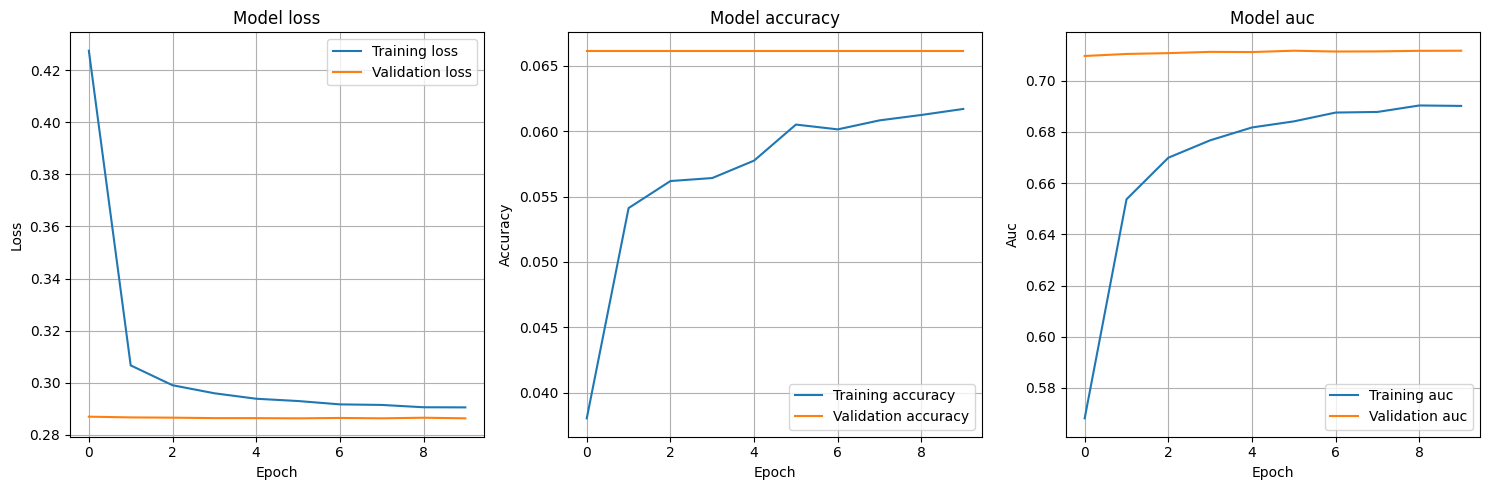

In [ ]:
# Create and train the BiLSTM model for tf-idf data

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import time

def create_bilstm_model_tfidf(input_shape, output_dim, lstm_units=64):
    """
    Create BiLSTM model for TF-IDF features.

    Args:
        input_shape: Tuple of (sequence_length, feature_dim)
        output_dim: Number of possible diagnoses
        lstm_units: Number of LSTM units (default: 64)
    """
    model = Sequential([
        # Input layer
        Input(shape=input_shape),

        # Bidirectional LSTM layer
        Bidirectional(
            LSTM(
                units=lstm_units,
                return_sequences=False,
                recurrent_dropout=0.2
            )
        ),

        # Dropout layer
        Dropout(0.8),

        # Output layer with sigmoid for multi-label
        Dense(output_dim, activation='sigmoid')
    ])

    # Compile with binary crossentropy for multi-label
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            AUC(name='auc'),
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )

    # Print model summary
    model.summary()

    return model

# Create the model
input_shape = (X_train_tfidf.shape[1], X_train_tfidf.shape[2])  # (sequence_length, feature_dim)
tfidf_model = create_bilstm_model_tfidf(
    input_shape=input_shape,
    output_dim=output_dim,
    lstm_units=100
)

# Create model checkpoint callback with .keras extension
checkpoint = ModelCheckpoint(
    'best_tfidf_model.keras',  # Changed from .h5 to .keras
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Start timing
start_time = time.time()

# Train the model
history = tfidf_model.fit(
    X_train_tfidf,
    y_train,
    validation_data=(X_val_tfidf, y_val),
    epochs=10,
    batch_size=400,
    callbacks=[checkpoint],
    verbose=1
)

# End timing
end_time = time.time()
training_duration = end_time - start_time

# Print training duration
print(f"Time to train the TF-IDF BiLSTM model: {training_duration:.2f} seconds")

def plot_training_history(history, metrics=['loss', 'accuracy', 'auc']):
    """
    Plot training history for specified metrics.

    Args:
        history: Keras history object
        metrics: List of metrics to plot
    """
    plt.figure(figsize=(15, 5))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, len(metrics), i)

        # Plot training and validation metrics
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')

        plt.title(f'Model {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# After training the model:
plot_training_history(history)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 200)                 │         183,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │          10,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193,250 (754.88 KB)

 Trainable params: 193,250 (754.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.0257 - auc: 0.5402 - loss: 0.5101 - precision: 0.1114 - recall: 0.2313
Epoch 1: val_auc improved from -inf to 0.71322, saving model to best_w2v_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 293ms/step - accuracy: 0.0259 - auc: 0.5408 - loss: 0.5083 - precision: 0.1117 - recall: 0.2294 - val_accuracy: 0.0662 - val_auc: 0.7132 - val_loss: 0.2863 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.0582 - auc: 0.6505 - loss: 0.3104 - precision: 0.3136 - recall: 0.0295
Epoch 2: val_auc improved from 0.71322 to 0.74938, saving model to best_w2v_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 267ms/step - accuracy: 0.0583 - auc: 0.6508 - loss: 0.3102 - precision: 0.3142 - recall: 0.0296 - val_accuracy: 0.1301 - val_auc: 0.7494 - val_loss: 0.2748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.0916 - 

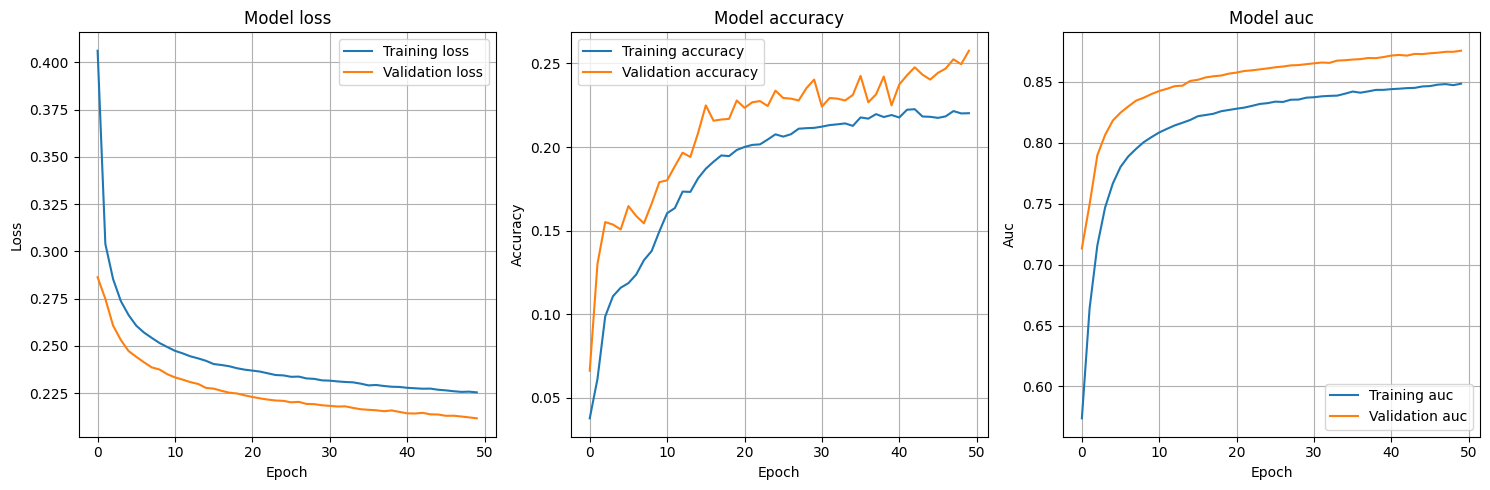

In [ ]:
# Create and train the BiLSTM model for Word2Vec data

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.metrics import AUC, Precision, Recall
import time
from tensorflow.keras.callbacks import ModelCheckpoint

def create_bilstm_model_w2v(input_shape, output_dim, lstm_units=64):
    """
    Create BiLSTM model for Word2Vec features.

    Args:
        input_shape: Tuple of (sequence_length, embedding_dim)
        output_dim: Number of possible diagnoses
        lstm_units: Number of LSTM units (default: 64)
    """
    model = Sequential([
        # Input layer
        Input(shape=input_shape),

        # Bidirectional LSTM layer
        Bidirectional(
            LSTM(
                units=lstm_units,
                return_sequences=False,
                recurrent_dropout=0.2
            )
        ),

        # Dropout layer
        Dropout(0.8),

        # Output layer with sigmoid for multi-label
        Dense(output_dim, activation='sigmoid')
    ])

    # Compile with binary crossentropy for multi-label
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            AUC(name='auc'),
            Precision(name='precision'),
            Recall(name='recall')
        ]
    )

    # Print model summary
    model.summary()

    return model


# Create the model
input_shape = (X_train_w2v.shape[1], X_train_w2v.shape[2])  # (sequence_length, embedding_dim)
w2v_model = create_bilstm_model_w2v(
    input_shape=input_shape,
    output_dim=output_dim,
    lstm_units=100
)

# Create model checkpoint callback
checkpoint = ModelCheckpoint(
    'best_w2v_model.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Start timing
start_time = time.time()

# Train the model
history_w2v = w2v_model.fit(
    X_train_w2v,
    y_train,
    validation_data=(X_val_w2v, y_val),
    epochs=50,
    batch_size=400,
    callbacks=[checkpoint],
    verbose=1
)

# End timing
end_time = time.time()
training_duration = end_time - start_time

# Print training duration
print(f"Time to train the Word2Vec BiLSTM model: {training_duration:.2f} seconds")

# Plot training history
plot_training_history(history_w2v)

Creating combined model...

Training combined model...
Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.0018 - auc: 0.4737 - loss: 0.0000e+00 - precision: 0.0771 - recall: 0.2542
Epoch 1: val_auc improved from -inf to 0.61433, saving model to best_combined_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 25s 348ms/step - accuracy: 0.0018 - auc: 0.4743 - loss: 0.0000e+00 - precision: 0.0771 - recall: 0.2523 - val_accuracy: 7.3502e-04 - val_auc: 0.6143 - val_loss: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.0454 - auc: 0.6463 - loss: 0.0000e+00 - precision: 0.1007 - recall: 7.2041e-04
Epoch 2: val_auc improved from 0.61433 to 0.70081, saving model to best_combined_model.keras
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 316ms/step - accuracy: 0.0456 - auc: 0.6467 - loss: 0.0000e+00 - precision: 0.1007 - recall: 7.1106e-04 - val_accuracy: 0.0662 - val_auc: 0.7008 - val_loss: 0.0000e+00 - val_precision: 0.0000e+

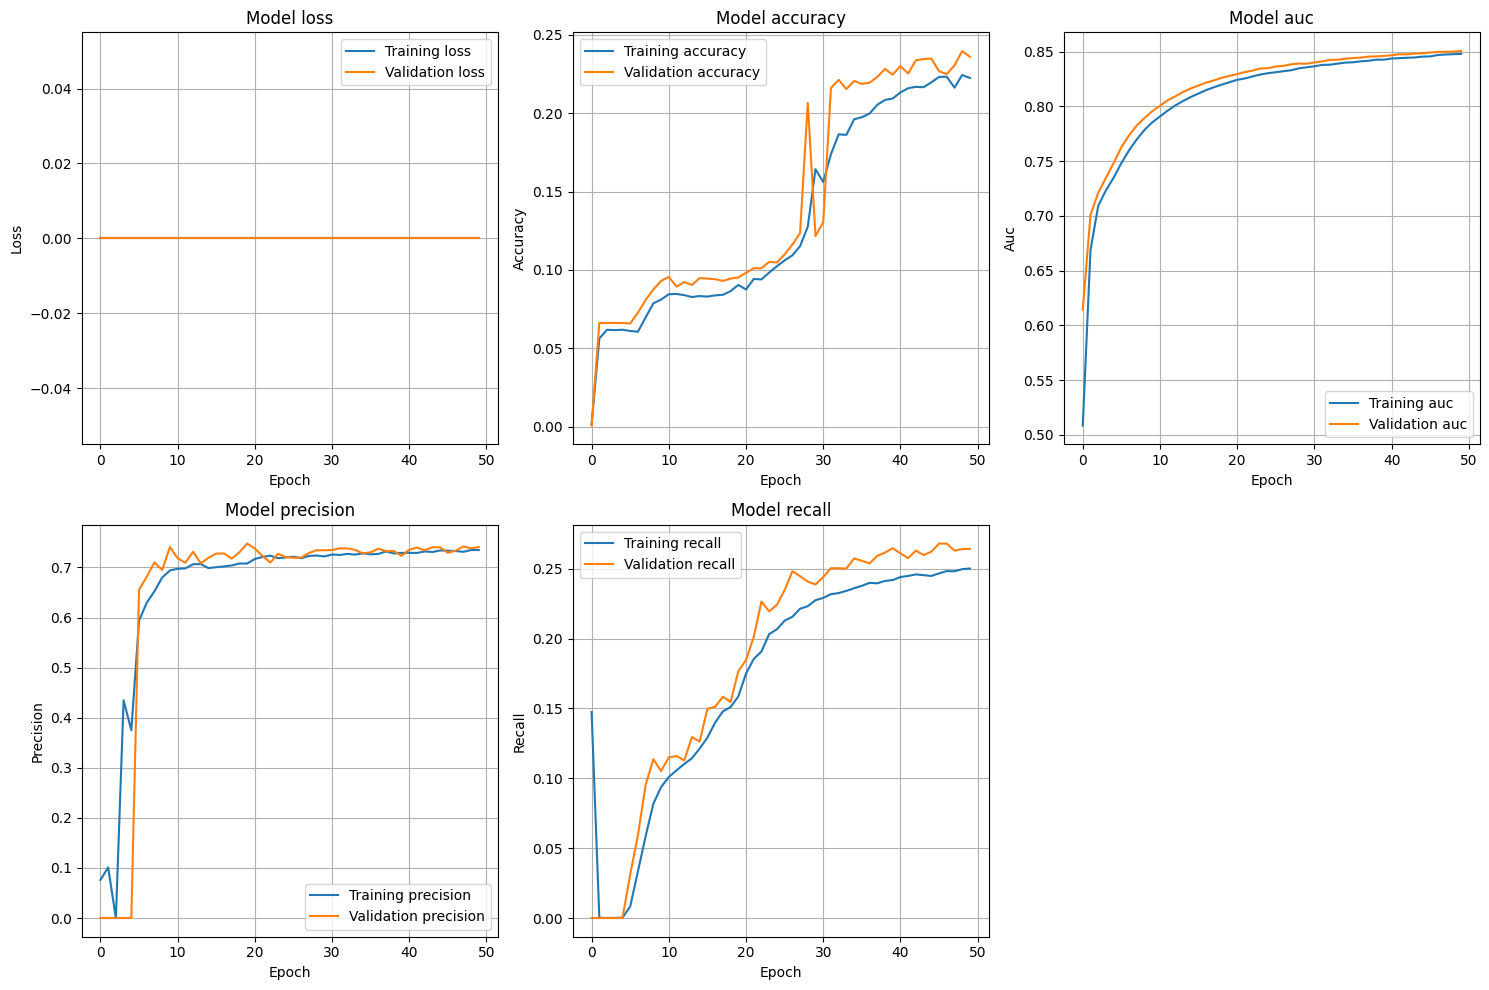


Final Training Metrics:
Loss      - Train: 0.000, Val: 0.000
Accuracy  - Train: 0.222, Val: 0.236
Auc       - Train: 0.848, Val: 0.851
Precision - Train: 0.735, Val: 0.741
Recall    - Train: 0.250, Val: 0.264


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import numpy as np
import time

def create_combined_model(model_tfidf, model_word2vec, input_shape_tfidf, input_shape_w2v, output_dim):
    """
    Create a combined model from pre-trained TF-IDF and Word2Vec models.
    """
    # Input layers
    input_tfidf = Input(shape=input_shape_tfidf)
    input_w2v = Input(shape=input_shape_w2v)

    # Get outputs from pre-trained models
    output_tfidf = model_tfidf(input_tfidf)
    output_w2v = model_word2vec(input_w2v)

    # Apply weights (0.5 each for equal contribution)
    weighted_output_tfidf = output_tfidf * 0.5
    weighted_output_w2v = output_w2v * 0.5

    # Combine outputs
    combined_output = Add()([weighted_output_tfidf, weighted_output_w2v])

    # Final output layer with sigmoid for multi-label
    final_output = Dense(output_dim, activation='sigmoid')(combined_output)

    # Create model
    model = Model(inputs=[input_tfidf, input_w2v], outputs=final_output)

    # Compile model
    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            AUC(name='auc')
        ]
    )

    return model

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def evaluate_predictions(y_true, y_pred, threshold=0.2):
    """
    Evaluate multi-label predictions using both micro and macro averaging.

    Args:
        y_true: Ground truth labels
        y_pred: Model predictions (probabilities)
        threshold: Classification threshold (0.2 as per paper)

    Returns:
        dict: Dictionary containing micro and macro metrics
    """
    # Convert probabilities to binary predictions using 0.2 threshold
    y_pred_binary = (y_pred >= threshold).astype(int)

    # Calculate macro metrics
    macro_precision = precision_score(y_true, y_pred_binary, average='macro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred_binary, average='macro', zero_division=0)
    macro_f1 = f1_score(y_true, y_pred_binary, average='macro', zero_division=0)
    try:
        macro_auc = roc_auc_score(y_true, y_pred, average='macro')
    except:
        macro_auc = 0  # Handle cases where some classes might not have both positive and negative samples

    # Calculate micro metrics
    micro_precision = precision_score(y_true, y_pred_binary, average='micro', zero_division=0)
    micro_recall = recall_score(y_true, y_pred_binary, average='micro', zero_division=0)
    micro_f1 = f1_score(y_true, y_pred_binary, average='micro', zero_division=0)
    try:
        micro_auc = roc_auc_score(y_true, y_pred, average='micro')
    except:
        micro_auc = 0

    metrics = {
        'macro': {
            'precision': macro_precision,
            'recall': macro_recall,
            'f1': macro_f1,
            'auc': macro_auc
        },
        'micro': {
            'precision': micro_precision,
            'recall': micro_recall,
            'f1': micro_f1,
            'auc': micro_auc
        }
    }

    return metrics

# Create and train combined model
print("Creating combined model...")
combined_model = create_combined_model(
    model_tfidf=tfidf_model,
    model_word2vec=w2v_model,
    input_shape_tfidf=(X_train_tfidf.shape[1], X_train_tfidf.shape[2]),
    input_shape_w2v=(X_train_w2v.shape[1], X_train_w2v.shape[2]),
    output_dim=output_dim
)

# Create checkpoint callback
checkpoint = ModelCheckpoint(
    'best_combined_model.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Train model
print("\nTraining combined model...")
start_time = time.time()

history = combined_model.fit(
    [X_train_tfidf, X_train_w2v],
    y_train,
    validation_data=([X_val_tfidf, X_val_w2v], y_val),
    epochs=50,
    batch_size=400,
    callbacks=[checkpoint],
    verbose=1
)

training_time = time.time() - start_time

# Evaluate the model:
print("\nEvaluating model with threshold=0.2 (as per paper)...")
y_pred = combined_model.predict([X_val_tfidf, X_val_w2v])
metrics = evaluate_predictions(y_val, y_pred, threshold=0.2)

# Print results
print("\nResults (threshold=0.2):")
print("\nMacro-averaging metrics:")
print(f"Precision: {metrics['macro']['precision']:.3f}")
print(f"Recall:    {metrics['macro']['recall']:.3f}")
print(f"F1 Score:  {metrics['macro']['f1']:.3f}")
print(f"AUC:       {metrics['macro']['auc']:.3f}")

print("\nMicro-averaging metrics:")
print(f"Precision: {metrics['micro']['precision']:.3f}")
print(f"Recall:    {metrics['micro']['recall']:.3f}")
print(f"F1 Score:  {metrics['micro']['f1']:.3f}")
print(f"AUC:       {metrics['micro']['auc']:.3f}")

print(f"\nTraining Time: {training_time:.2f} seconds")

def plot_learning_curves(history, metrics=['loss', 'accuracy', 'auc', 'precision', 'recall']):
    """
    Plot learning curves for the combined model.

    Args:
        history: Training history from model.fit()
        metrics: List of metrics to plot
    """
    n_metrics = len(metrics)
    n_rows = (n_metrics + 2) // 3  # Calculate number of rows needed (3 plots per row)
    n_cols = min(3, n_metrics)

    plt.figure(figsize=(15, 5*n_rows))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(n_rows, n_cols, i)

        # Plot training metrics
        plt.plot(history.history[metric], label=f'Training {metric}')

        # Plot validation metrics
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f'Validation {metric}')

        plt.title(f'Model {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot learning curves
print("Learning Curves for Combined Model:")
plot_learning_curves(history)

# Add summary statistics
print("\nFinal Training Metrics:")
for metric in ['loss', 'accuracy', 'auc', 'precision', 'recall']:
    final_train = history.history[metric][-1]
    final_val = history.history[f'val_{metric}'][-1]
    print(f"{metric.capitalize():9} - Train: {final_train:.3f}, Val: {final_val:.3f}")

In [ ]:
def print_metrics(metrics, dataset_name):
    """Helper function to print metrics in a consistent format"""
    print(f"\n{dataset_name} Results (threshold=0.2):")
    print("\nMacro-averaging metrics:")
    print(f"Precision: {metrics['macro']['precision']:.3f}")
    print(f"Recall:    {metrics['macro']['recall']:.3f}")
    print(f"F1 Score:  {metrics['macro']['f1']:.3f}")
    print(f"AUC:       {metrics['macro']['auc']:.3f}")

    print("\nMicro-averaging metrics:")
    print(f"Precision: {metrics['micro']['precision']:.3f}")
    print(f"Recall:    {metrics['micro']['recall']:.3f}")
    print(f"F1 Score:  {metrics['micro']['f1']:.3f}")
    print(f"AUC:       {metrics['micro']['auc']:.3f}")

# Evaluate on validation set
print("\nEvaluating model on validation set...")
y_val_pred = combined_model.predict([X_val_tfidf, X_val_w2v])
val_metrics = evaluate_predictions(y_val, y_val_pred, threshold=0.2)
print_metrics(val_metrics, "Validation")

# Evaluate on test set
print("\nEvaluating model on test set...")
y_test_pred = combined_model.predict([X_test_tfidf, X_test_w2v])
test_metrics = evaluate_predictions(y_test, y_test_pred, threshold=0.2)
print_metrics(test_metrics, "Test")

print(f"\nTraining Time: {training_time:.2f} seconds")

# Compare validation and test performance
print("\nValidation vs Test Performance Comparison:")
for metric_type in ['macro', 'micro']:
    print(f"\n{metric_type.capitalize()}-averaging metrics:")
    for metric in ['precision', 'recall', 'f1', 'auc']:
        val_score = val_metrics[metric_type][metric]
        test_score = test_metrics[metric_type][metric]
        diff = abs(val_score - test_score)
        print(f"{metric.capitalize():9} - Val: {val_score:.3f}, Test: {test_score:.3f} (Δ: {diff:.3f})")


Evaluating model on validation set...
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step

Validation Results (threshold=0.2):

Macro-averaging metrics:
Precision: 0.230
Recall:    0.300
F1 Score:  0.239
AUC:       0.768

Micro-averaging metrics:
Precision: 0.444
Recall:    0.509
F1 Score:  0.474
AUC:       0.851

Evaluating model on test set...
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step

Test Results (threshold=0.2):

Macro-averaging metrics:
Precision: 0.229
Recall:    0.301
F1 Score:  0.239
AUC:       0.761

Micro-averaging metrics:
Precision: 0.437
Recall:    0.504
F1 Score:  0.468
AUC:       0.844

Training Time: 889.71 seconds

Validation vs Test Performance Comparison:

Macro-averaging metrics:
Precision - Val: 0.230, Test: 0.229 (Δ: 0.001)
Recall    - Val: 0.300, Test: 0.301 (Δ: 0.001)
F1        - Val: 0.239, Test: 0.239 (Δ: 0.000)
Auc       - Val: 0.768, Test: 0.761 (Δ: 0.006)

Micro-averaging metrics:
Precision - Val: 0.444, Test: 0.437 (Δ: 0.007)
Recall    - Val: 0.509, Test: 0.504 (Δ: 0.

In [ ]:
# Evaluate TF-IDF model
print("\nEvaluating TF-IDF model on validation set...")
y_val_pred_tfidf = tfidf_model.predict(X_val_tfidf)
val_metrics_tfidf = evaluate_predictions(y_val, y_val_pred_tfidf, threshold=0.2)
print_metrics(val_metrics_tfidf, "TF-IDF Validation")

print("\nEvaluating TF-IDF model on test set...")
y_test_pred_tfidf = tfidf_model.predict(X_test_tfidf)
test_metrics_tfidf = evaluate_predictions(y_test, y_test_pred_tfidf, threshold=0.2)
print_metrics(test_metrics_tfidf, "TF-IDF Test")

# Evaluate Word2Vec model
print("\nEvaluating Word2Vec model on validation set...")
y_val_pred_w2v = w2v_model.predict(X_val_w2v)
val_metrics_w2v = evaluate_predictions(y_val, y_val_pred_w2v, threshold=0.2)
print_metrics(val_metrics_w2v, "Word2Vec Validation")

print("\nEvaluating Word2Vec model on test set...")
y_test_pred_w2v = w2v_model.predict(X_test_w2v)
test_metrics_w2v = evaluate_predictions(y_test, y_test_pred_w2v, threshold=0.2)
print_metrics(test_metrics_w2v, "Word2Vec Test")


Evaluating TF-IDF model on validation set...
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step

TF-IDF Validation Results (threshold=0.2):

Macro-averaging metrics:
Precision: 0.095
Recall:    1.000
F1 Score:  0.165
AUC:       0.500

Micro-averaging metrics:
Precision: 0.095
Recall:    1.000
F1 Score:  0.173
AUC:       0.327

Evaluating TF-IDF model on test set...
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step

TF-IDF Test Results (threshold=0.2):

Macro-averaging metrics:
Precision: 0.096
Recall:    1.000
F1 Score:  0.167
AUC:       0.500

Micro-averaging metrics:
Precision: 0.096
Recall:    1.000
F1 Score:  0.175
AUC:       0.328

Evaluating Word2Vec model on validation set...
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step

Word2Vec Validation Results (threshold=0.2):

Macro-averaging metrics:
Precision: 0.084
Recall:    0.575
F1 Score:  0.137
AUC:       0.474

Micro-averaging metrics:
Precision: 0.091
Recall:    0.563
F1 Score:  0.156
AUC:       0.495

Evaluating Word2Vec model on test set...
86/86 ━━━━━━